In [24]:
!ls -lh RML2016.10a_dict.dat

-rw-r--r-- 1 root root 614M Dec 15 14:45 RML2016.10a_dict.dat


In [11]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib
#matplotlib.use('Tkagg')
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle,sys,h5py
import keras
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.regularizers import *
from keras.optimizers import Adam
from keras.models import model_from_json
import mltools,dataset2016
import MCLDNN as mcl
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import csv

In [16]:
def output_layer(model,flag=None):
    if flag=='conv2':
        model=Model(inputs=model.inputs,outputs =model.get_layer('conv2').output)
    elif flag=='conv4':
        model=Model(inputs=model.inputs,outputs =model.get_layer('conv4').output)
    elif flag=='cu_dnnlstm_2':
        model=Model(inputs=model.inputs,outputs =model.get_layer('cu_dnnlstm_2').output)
    else:
        return model

    return model

# Set Keras data format as channels_last
K.set_image_data_format('channels_last')
print(K.image_data_format())

channels_last


In [25]:
(mods,snrs,lbl),(X_train,Y_train),(X_val,Y_val),(X_test,Y_test),(train_idx,val_idx,test_idx) = \
    dataset2016.load_data(filename="/content/RML2016.10a_dict.dat")

In [26]:
X1_train=np.expand_dims(X_train[:,0,:], axis=2)
X1_test=np.expand_dims(X_test[:,0,:], axis=2)
X1_val=np.expand_dims(X_val[:,0,:],axis=2)
X2_train=np.expand_dims(X_train[:,1,:], axis=2)
X2_test=np.expand_dims(X_test[:,1,:], axis=2)
X2_val=np.expand_dims(X_val[:,1,:],axis=2)
X_train=np.expand_dims(X_train,axis=3)
X_test=np.expand_dims(X_test,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape)

print(X_test.shape)
classes = mods


(132000, 2, 128, 1)
(44000, 2, 128, 1)


In [28]:
nb_epoch = 100     # number of epochs to train on
batch_size = 400

In [30]:
model=mcl.MCLDNN()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input2 (InputLayer) │ (None, 128, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 128, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv1D)    │ (None, 128, 50)   │        450 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_3 (Conv1D)    │ (None, 128, 50)   │        450 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 128,    │          0 │ conv1_2[0][0]     │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshap2 (Reshape)   │ (None, 1, 128,    │          0 │ conv1_3[0][0]     │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input1 (InputLayer) │ (None, 2, 128, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2, 128,    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │ 50)               │            │ reshap2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 2, 128,    │        850 │ input1[0][0]      │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 2, 128,    │     20,050 │ concatenate_2[0]… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 2, 128,    │          0 │ conv1_1[0][0],    │
│ (Concatenate)       │ 100)              │            │ conv2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv2D)      │ (None, 1, 124,    │    100,100 │ concatenate_3[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 124, 100)  │          0 │ conv4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 124, 128)  │    117,248 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    131,584 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 128)       │     16,512 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc2 (Dense)         │ (None, 128)       │     16,512 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ fc2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 11)        │      1,419 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,175 (1.55 MB)

 Trainable params: 405,175 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
filepath = 'weights/weights.h5'



modtype=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM']


Epoch 1/100

Epoch 1: val_loss improved from inf to 2.06485, saving model to weights/weights.h5


330/330 - 31s - 93ms/step - accuracy: 0.1763 - loss: 2.1837 - val_accuracy: 0.2074 - val_loss: 2.0648 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_loss improved from 2.06485 to 1.76019, saving model to weights/weights.h5


330/330 - 23s - 68ms/step - accuracy: 0.2582 - loss: 1.9646 - val_accuracy: 0.3404 - val_loss: 1.7602 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_loss improved from 1.76019 to 1.73164, saving model to weights/weights.h5


330/330 - 23s - 70ms/step - accuracy: 0.3636 - loss: 1.6830 - val_accuracy: 0.3277 - val_loss: 1.7316 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_loss improved from 1.73164 to 1.50438, saving model to weights/weights.h5


330/330 - 23s - 70ms/step - accuracy: 0.4009 - loss: 1.5737 - val_accuracy: 0.4219 - val_loss: 1.5044 - learning_rate: 1.0000e-03
Epoch 5/100

Epoch 5: val_loss did not improve from 1.50438
330/330 - 24s - 72ms/step - accuracy: 0.4288 - loss: 1.5153 - val_accuracy: 0.3617 - val_loss: 1.7218 - learning_rate: 1.0000e-03
Epoch 6/100

Epoch 6: val_loss improved from 1.50438 to 1.42826, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.4285 - loss: 1.5148 - val_accuracy: 0.4481 - val_loss: 1.4283 - learning_rate: 1.0000e-03
Epoch 7/100

Epoch 7: val_loss improved from 1.42826 to 1.41488, saving model to weights/weights.h5


330/330 - 41s - 124ms/step - accuracy: 0.4214 - loss: 1.5306 - val_accuracy: 0.4624 - val_loss: 1.4149 - learning_rate: 1.0000e-03
Epoch 8/100

Epoch 8: val_loss improved from 1.41488 to 1.39688, saving model to weights/weights.h5


330/330 - 24s - 72ms/step - accuracy: 0.4781 - loss: 1.3962 - val_accuracy: 0.4799 - val_loss: 1.3969 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: val_loss did not improve from 1.39688
330/330 - 23s - 71ms/step - accuracy: 0.4929 - loss: 1.3694 - val_accuracy: 0.3394 - val_loss: 1.7784 - learning_rate: 1.0000e-03
Epoch 10/100

Epoch 10: val_loss improved from 1.39688 to 1.29322, saving model to weights/weights.h5


330/330 - 23s - 70ms/step - accuracy: 0.4784 - loss: 1.4124 - val_accuracy: 0.5143 - val_loss: 1.2932 - learning_rate: 1.0000e-03
Epoch 11/100

Epoch 11: val_loss improved from 1.29322 to 1.27229, saving model to weights/weights.h5


330/330 - 23s - 70ms/step - accuracy: 0.5144 - loss: 1.3104 - val_accuracy: 0.5272 - val_loss: 1.2723 - learning_rate: 1.0000e-03
Epoch 12/100

Epoch 12: val_loss did not improve from 1.27229
330/330 - 23s - 71ms/step - accuracy: 0.5194 - loss: 1.2936 - val_accuracy: 0.5229 - val_loss: 1.2854 - learning_rate: 1.0000e-03
Epoch 13/100

Epoch 13: val_loss improved from 1.27229 to 1.27069, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5232 - loss: 1.2836 - val_accuracy: 0.5239 - val_loss: 1.2707 - learning_rate: 1.0000e-03
Epoch 14/100

Epoch 14: val_loss improved from 1.27069 to 1.23429, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5295 - loss: 1.2654 - val_accuracy: 0.5360 - val_loss: 1.2343 - learning_rate: 1.0000e-03
Epoch 15/100

Epoch 15: val_loss did not improve from 1.23429
330/330 - 23s - 71ms/step - accuracy: 0.5307 - loss: 1.2622 - val_accuracy: 0.5368 - val_loss: 1.2451 - learning_rate: 1.0000e-03
Epoch 16/100

Epoch 16: val_loss improved from 1.23429 to 1.22075, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5317 - loss: 1.2565 - val_accuracy: 0.5423 - val_loss: 1.2207 - learning_rate: 1.0000e-03
Epoch 17/100

Epoch 17: val_loss did not improve from 1.22075
330/330 - 23s - 70ms/step - accuracy: 0.5377 - loss: 1.2367 - val_accuracy: 0.5408 - val_loss: 1.2320 - learning_rate: 1.0000e-03
Epoch 18/100

Epoch 18: val_loss did not improve from 1.22075
330/330 - 23s - 71ms/step - accuracy: 0.5399 - loss: 1.2329 - val_accuracy: 0.5125 - val_loss: 1.3461 - learning_rate: 1.0000e-03
Epoch 19/100

Epoch 19: val_loss improved from 1.22075 to 1.21432, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5321 - loss: 1.2577 - val_accuracy: 0.5432 - val_loss: 1.2143 - learning_rate: 1.0000e-03
Epoch 20/100

Epoch 20: val_loss did not improve from 1.21432
330/330 - 23s - 70ms/step - accuracy: 0.5354 - loss: 1.2455 - val_accuracy: 0.5343 - val_loss: 1.2371 - learning_rate: 1.0000e-03
Epoch 21/100

Epoch 21: val_loss did not improve from 1.21432
330/330 - 23s - 70ms/step - accuracy: 0.5420 - loss: 1.2225 - val_accuracy: 0.5405 - val_loss: 1.2267 - learning_rate: 1.0000e-03
Epoch 22/100

Epoch 22: val_loss did not improve from 1.21432
330/330 - 23s - 71ms/step - accuracy: 0.5433 - loss: 1.2197 - val_accuracy: 0.5435 - val_loss: 1.2154 - learning_rate: 1.0000e-03
Epoch 23/100

Epoch 23: val_loss improved from 1.21432 to 1.19676, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5469 - loss: 1.2137 - val_accuracy: 0.5534 - val_loss: 1.1968 - learning_rate: 1.0000e-03
Epoch 24/100

Epoch 24: val_loss did not improve from 1.19676
330/330 - 26s - 78ms/step - accuracy: 0.5486 - loss: 1.2065 - val_accuracy: 0.5470 - val_loss: 1.2083 - learning_rate: 1.0000e-03
Epoch 25/100

Epoch 25: val_loss did not improve from 1.19676
330/330 - 39s - 117ms/step - accuracy: 0.5494 - loss: 1.2022 - val_accuracy: 0.5528 - val_loss: 1.1970 - learning_rate: 1.0000e-03
Epoch 26/100

Epoch 26: val_loss improved from 1.19676 to 1.19466, saving model to weights/weights.h5


330/330 - 24s - 72ms/step - accuracy: 0.5502 - loss: 1.2037 - val_accuracy: 0.5470 - val_loss: 1.1947 - learning_rate: 1.0000e-03
Epoch 27/100

Epoch 27: val_loss improved from 1.19466 to 1.18667, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5475 - loss: 1.2097 - val_accuracy: 0.5549 - val_loss: 1.1867 - learning_rate: 1.0000e-03
Epoch 28/100

Epoch 28: val_loss did not improve from 1.18667
330/330 - 23s - 71ms/step - accuracy: 0.5521 - loss: 1.1945 - val_accuracy: 0.5518 - val_loss: 1.1955 - learning_rate: 1.0000e-03
Epoch 29/100

Epoch 29: val_loss improved from 1.18667 to 1.18317, saving model to weights/weights.h5


330/330 - 24s - 72ms/step - accuracy: 0.5495 - loss: 1.2008 - val_accuracy: 0.5516 - val_loss: 1.1832 - learning_rate: 1.0000e-03
Epoch 30/100

Epoch 30: val_loss improved from 1.18317 to 1.17649, saving model to weights/weights.h5


330/330 - 24s - 71ms/step - accuracy: 0.5518 - loss: 1.1923 - val_accuracy: 0.5584 - val_loss: 1.1765 - learning_rate: 1.0000e-03
Epoch 31/100

Epoch 31: val_loss did not improve from 1.17649
330/330 - 23s - 71ms/step - accuracy: 0.5550 - loss: 1.1857 - val_accuracy: 0.5570 - val_loss: 1.1864 - learning_rate: 1.0000e-03
Epoch 32/100

Epoch 32: val_loss did not improve from 1.17649
330/330 - 23s - 71ms/step - accuracy: 0.5556 - loss: 1.1822 - val_accuracy: 0.5592 - val_loss: 1.1789 - learning_rate: 1.0000e-03
Epoch 33/100

Epoch 33: val_loss improved from 1.17649 to 1.17274, saving model to weights/weights.h5


330/330 - 24s - 72ms/step - accuracy: 0.5584 - loss: 1.1771 - val_accuracy: 0.5583 - val_loss: 1.1727 - learning_rate: 1.0000e-03
Epoch 34/100

Epoch 34: val_loss did not improve from 1.17274
330/330 - 23s - 71ms/step - accuracy: 0.5601 - loss: 1.1750 - val_accuracy: 0.5562 - val_loss: 1.1806 - learning_rate: 1.0000e-03
Epoch 35/100

Epoch 35: val_loss improved from 1.17274 to 1.16522, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5597 - loss: 1.1706 - val_accuracy: 0.5611 - val_loss: 1.1652 - learning_rate: 1.0000e-03
Epoch 36/100

Epoch 36: val_loss did not improve from 1.16522
330/330 - 23s - 71ms/step - accuracy: 0.5632 - loss: 1.1669 - val_accuracy: 0.5553 - val_loss: 1.1786 - learning_rate: 1.0000e-03
Epoch 37/100

Epoch 37: val_loss did not improve from 1.16522
330/330 - 23s - 71ms/step - accuracy: 0.5635 - loss: 1.1616 - val_accuracy: 0.5635 - val_loss: 1.1654 - learning_rate: 1.0000e-03
Epoch 38/100

Epoch 38: val_loss did not improve from 1.16522
330/330 - 23s - 71ms/step - accuracy: 0.5656 - loss: 1.1608 - val_accuracy: 0.5613 - val_loss: 1.1691 - learning_rate: 1.0000e-03
Epoch 39/100

Epoch 39: val_loss did not improve from 1.16522
330/330 - 23s - 71ms/step - accuracy: 0.5659 - loss: 1.1608 - val_accuracy: 0.5590 - val_loss: 1.1906 - learning_rate: 1.0000e-03
Epoch 40/100

Epoch 40: val_loss improved from 1.16522 to 1.16503, saving model to weights/weights.h5


330/330 - 24s - 71ms/step - accuracy: 0.5700 - loss: 1.1524 - val_accuracy: 0.5620 - val_loss: 1.1650 - learning_rate: 1.0000e-03
Epoch 41/100

Epoch 41: val_loss did not improve from 1.16503
330/330 - 23s - 71ms/step - accuracy: 0.5734 - loss: 1.1450 - val_accuracy: 0.5634 - val_loss: 1.1718 - learning_rate: 1.0000e-03
Epoch 42/100

Epoch 42: val_loss improved from 1.16503 to 1.15738, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5750 - loss: 1.1396 - val_accuracy: 0.5708 - val_loss: 1.1574 - learning_rate: 1.0000e-03
Epoch 43/100

Epoch 43: val_loss did not improve from 1.15738
330/330 - 23s - 71ms/step - accuracy: 0.5783 - loss: 1.1348 - val_accuracy: 0.5715 - val_loss: 1.1599 - learning_rate: 1.0000e-03
Epoch 44/100

Epoch 44: val_loss improved from 1.15738 to 1.14987, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5820 - loss: 1.1264 - val_accuracy: 0.5751 - val_loss: 1.1499 - learning_rate: 1.0000e-03
Epoch 45/100

Epoch 45: val_loss improved from 1.14987 to 1.14177, saving model to weights/weights.h5


330/330 - 26s - 78ms/step - accuracy: 0.5866 - loss: 1.1175 - val_accuracy: 0.5835 - val_loss: 1.1418 - learning_rate: 1.0000e-03
Epoch 46/100

Epoch 46: val_loss did not improve from 1.14177
330/330 - 23s - 71ms/step - accuracy: 0.5908 - loss: 1.1106 - val_accuracy: 0.5771 - val_loss: 1.1487 - learning_rate: 1.0000e-03
Epoch 47/100

Epoch 47: val_loss improved from 1.14177 to 1.14066, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.5943 - loss: 1.1050 - val_accuracy: 0.5810 - val_loss: 1.1407 - learning_rate: 1.0000e-03
Epoch 48/100

Epoch 48: val_loss improved from 1.14066 to 1.13309, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.6008 - loss: 1.0926 - val_accuracy: 0.5865 - val_loss: 1.1331 - learning_rate: 1.0000e-03
Epoch 49/100

Epoch 49: val_loss improved from 1.13309 to 1.13200, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.6070 - loss: 1.0791 - val_accuracy: 0.5918 - val_loss: 1.1320 - learning_rate: 1.0000e-03
Epoch 50/100

Epoch 50: val_loss improved from 1.13200 to 1.12052, saving model to weights/weights.h5


330/330 - 26s - 78ms/step - accuracy: 0.6104 - loss: 1.0701 - val_accuracy: 0.5895 - val_loss: 1.1205 - learning_rate: 1.0000e-03
Epoch 51/100

Epoch 51: val_loss improved from 1.12052 to 1.10598, saving model to weights/weights.h5


330/330 - 26s - 78ms/step - accuracy: 0.6174 - loss: 1.0571 - val_accuracy: 0.5988 - val_loss: 1.1060 - learning_rate: 1.0000e-03
Epoch 52/100

Epoch 52: val_loss improved from 1.10598 to 1.10371, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.6225 - loss: 1.0422 - val_accuracy: 0.6035 - val_loss: 1.1037 - learning_rate: 1.0000e-03
Epoch 53/100

Epoch 53: val_loss did not improve from 1.10371
330/330 - 23s - 71ms/step - accuracy: 0.6271 - loss: 1.0297 - val_accuracy: 0.6000 - val_loss: 1.1223 - learning_rate: 1.0000e-03
Epoch 54/100

Epoch 54: val_loss did not improve from 1.10371
330/330 - 23s - 70ms/step - accuracy: 0.6291 - loss: 1.0225 - val_accuracy: 0.6047 - val_loss: 1.1063 - learning_rate: 1.0000e-03
Epoch 55/100

Epoch 55: val_loss did not improve from 1.10371
330/330 - 23s - 71ms/step - accuracy: 0.6340 - loss: 1.0074 - val_accuracy: 0.6040 - val_loss: 1.1153 - learning_rate: 1.0000e-03
Epoch 56/100

Epoch 56: val_loss improved from 1.10371 to 1.09424, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.6372 - loss: 0.9989 - val_accuracy: 0.6111 - val_loss: 1.0942 - learning_rate: 1.0000e-03
Epoch 57/100

Epoch 57: val_loss improved from 1.09424 to 1.09343, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.6409 - loss: 0.9869 - val_accuracy: 0.6131 - val_loss: 1.0934 - learning_rate: 1.0000e-03
Epoch 58/100

Epoch 58: val_loss improved from 1.09343 to 1.09172, saving model to weights/weights.h5


330/330 - 23s - 71ms/step - accuracy: 0.6449 - loss: 0.9776 - val_accuracy: 0.6121 - val_loss: 1.0917 - learning_rate: 1.0000e-03
Epoch 59/100

Epoch 59: val_loss improved from 1.09172 to 1.08913, saving model to weights/weights.h5


330/330 - 24s - 71ms/step - accuracy: 0.6475 - loss: 0.9656 - val_accuracy: 0.6114 - val_loss: 1.0891 - learning_rate: 1.0000e-03
Epoch 60/100

Epoch 60: val_loss improved from 1.08913 to 1.08480, saving model to weights/weights.h5


330/330 - 23s - 70ms/step - accuracy: 0.6509 - loss: 0.9571 - val_accuracy: 0.6134 - val_loss: 1.0848 - learning_rate: 1.0000e-03
Epoch 61/100

Epoch 61: val_loss did not improve from 1.08480
330/330 - 23s - 71ms/step - accuracy: 0.6540 - loss: 0.9444 - val_accuracy: 0.6173 - val_loss: 1.0907 - learning_rate: 1.0000e-03
Epoch 62/100

Epoch 62: val_loss did not improve from 1.08480
330/330 - 23s - 70ms/step - accuracy: 0.6577 - loss: 0.9347 - val_accuracy: 0.6150 - val_loss: 1.0873 - learning_rate: 1.0000e-03
Epoch 63/100

Epoch 63: val_loss improved from 1.08480 to 1.08164, saving model to weights/weights.h5


330/330 - 24s - 71ms/step - accuracy: 0.6585 - loss: 0.9292 - val_accuracy: 0.6195 - val_loss: 1.0816 - learning_rate: 1.0000e-03
Epoch 64/100

Epoch 64: val_loss did not improve from 1.08164
330/330 - 23s - 71ms/step - accuracy: 0.6663 - loss: 0.9078 - val_accuracy: 0.6124 - val_loss: 1.0891 - learning_rate: 1.0000e-03
Epoch 65/100

Epoch 65: val_loss did not improve from 1.08164
330/330 - 24s - 71ms/step - accuracy: 0.6695 - loss: 0.8991 - val_accuracy: 0.6146 - val_loss: 1.1087 - learning_rate: 1.0000e-03
Epoch 66/100

Epoch 66: val_loss did not improve from 1.08164
330/330 - 24s - 72ms/step - accuracy: 0.6700 - loss: 0.8957 - val_accuracy: 0.6180 - val_loss: 1.1000 - learning_rate: 1.0000e-03
Epoch 67/100

Epoch 67: val_loss did not improve from 1.08164
330/330 - 23s - 71ms/step - accuracy: 0.6740 - loss: 0.8819 - val_accuracy: 0.6208 - val_loss: 1.0937 - learning_rate: 1.0000e-03
Epoch 68/100

Epoch 68: val_loss did not improve from 1.08164
330/330 - 23s - 71ms/step - accuracy: 0.

FileNotFoundError: [Errno 2] No such file or directory: 'figure/total_loss.png'

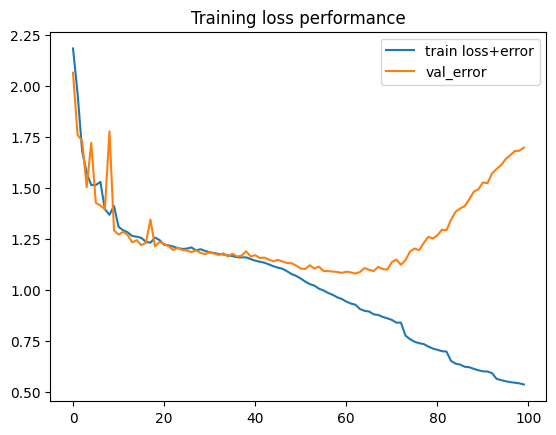

In [32]:
history = model.fit([X_train,X1_train,X2_train],
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=([X_val,X1_val,X2_val],Y_val),
    # validation_data=([X_test,X1_test,X2_test],Y_test),
    callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=5,min_lr=0.0000001),
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto'),
                # keras.callbacks.TensorBoard(histogram_freq=1,write_graph=True,write_images=True,batch_size=batch_size)
                ]
                    )
mltools.show_history(history)
# Show simple version of performance
score = model.evaluate([X_test,X1_test,X2_test], Y_test, verbose=1, batch_size=batch_size)
print(score)

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'figure/mclstm_total_confusion.png'

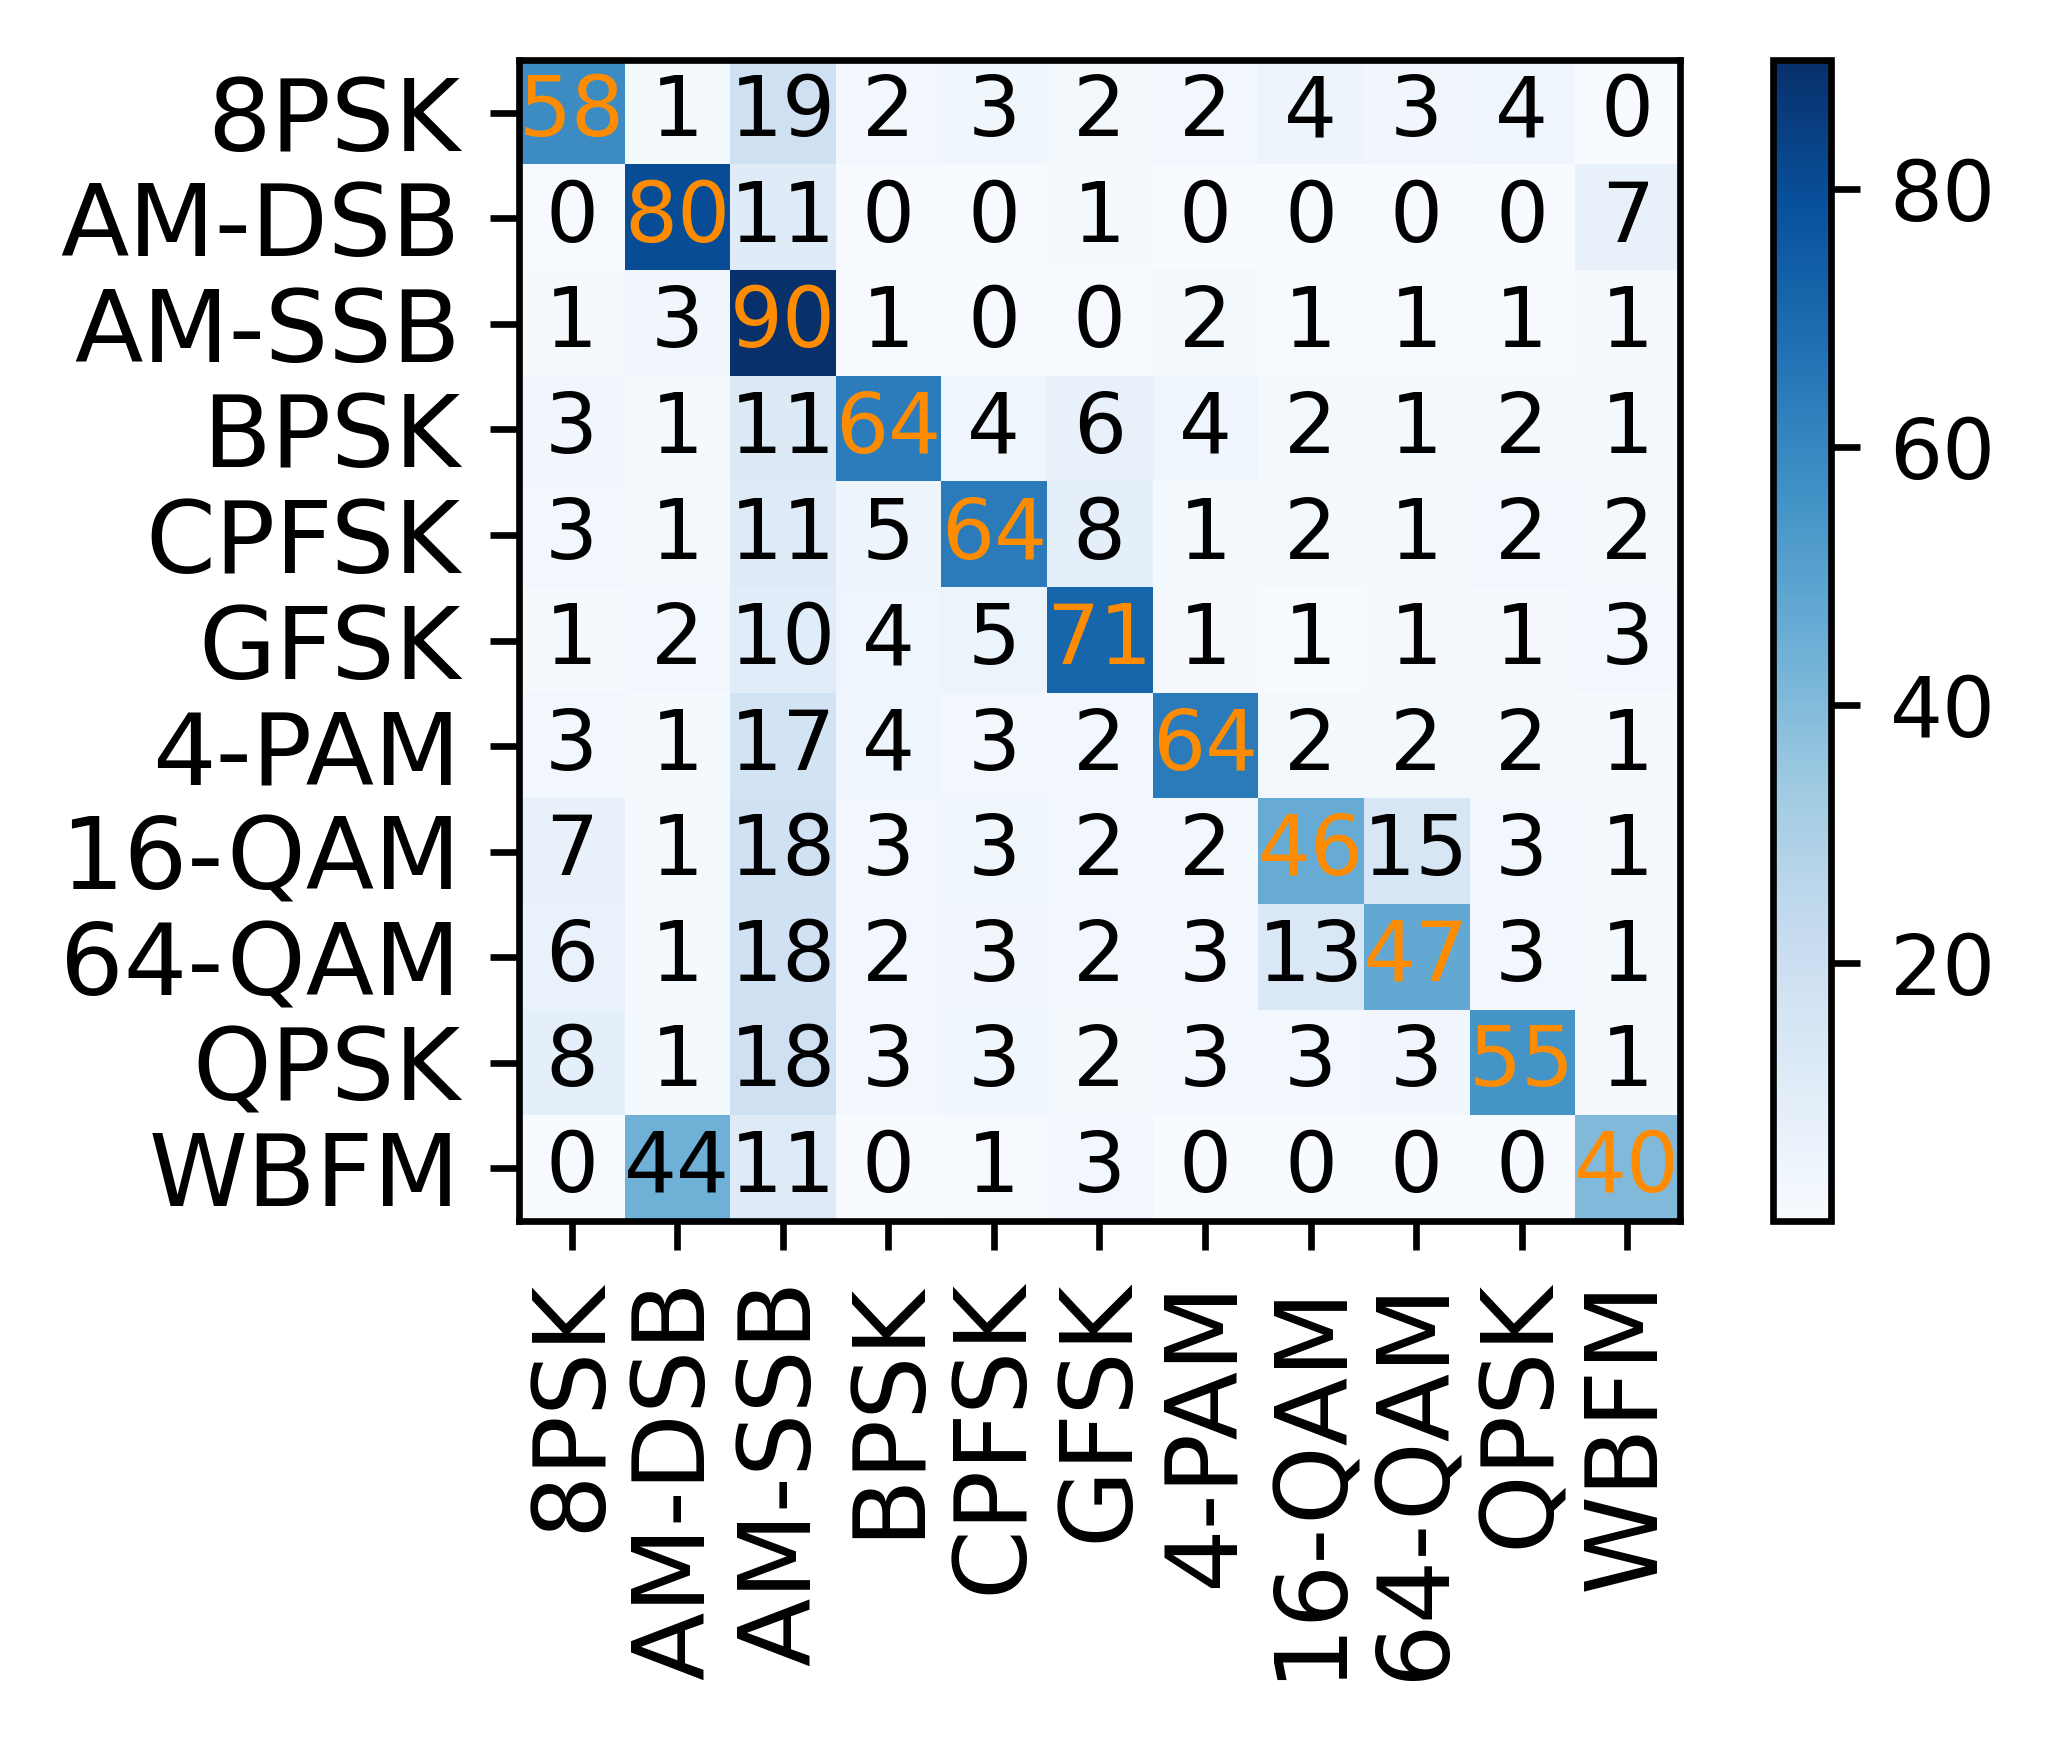

In [34]:
def predict(model):
    model.load_weights(filepath)
    # Plot confusion matrix
    test_Y_hat = model.predict([X_test,X1_test,X2_test], batch_size=batch_size)
    confnorm,_,_ = mltools.calculate_confusion_matrix(Y_test,test_Y_hat,classes)
    mltools.plot_confusion_matrix(confnorm, labels=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM'],save_filename='figure/mclstm_total_confusion.png')
    # Plot confusion matrix
    acc = {}
    acc_mod_snr = np.zeros( (len(classes),len(snrs)) )
    i = 0
    for snr in snrs:

        # Extract classes @ SNR
        test_SNRs = [lbl[x][1] for x in test_idx]
        test_X1_i = X1_test[np.where(np.array(test_SNRs) == snr)]
        test_X2_i = X2_test[np.where(np.array(test_SNRs) == snr)]
        test_X_i=X_test[np.where(np.array(test_SNRs) == snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

        # Estimate classes
        test_Y_i_hat = model.predict([test_X_i,test_X1_i,test_X2_i])
        confnorm_i,cor,ncor = mltools.calculate_confusion_matrix(test_Y_i,test_Y_i_hat,classes)
        acc[snr] = 1.0 * cor / (cor + ncor)
        result = cor / (cor + ncor)
        with open('acc111.csv', 'a', newline='') as f0:
            write0 = csv.writer(f0)
            write0.writerow([result])
        mltools.plot_confusion_matrix(confnorm_i, labels=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM'], title="Confusion Matrix" ,save_filename="figure/Confusion(SNR=%d)(ACC=%2f).png" % (snr,100.0*acc[snr]))
        acc_mod_snr[:,i] = np.round(np.diag(confnorm_i)/np.sum(confnorm_i,axis=1),3)
        i = i +1

    # Plot acc of each mod in one picture
    dis_num=11
    for g in range(int(np.ceil(acc_mod_snr.shape[0]/dis_num))):
        assert (0 <= dis_num <= acc_mod_snr.shape[0])
        beg_index = g*dis_num
        end_index = np.min([(g+1)*dis_num,acc_mod_snr.shape[0]])

        plt.figure(figsize=(12, 10))
        plt.xlabel("Signal to Noise Ratio")
        plt.ylabel("Classification Accuracy")
        plt.title("Classification Accuracy for Each Mod")

        for i in range(beg_index,end_index):
            plt.plot(snrs, acc_mod_snr[i], label=classes[i])
            # 设置数字标签
            for x, y in zip(snrs, acc_mod_snr[i]):
                plt.text(x, y, y, ha='center', va='bottom', fontsize=8)

        plt.legend()
        plt.grid()
        plt.savefig('figure/acc_with_mod_{}.png'.format(g+1))
        plt.close()
    # Save acc for mod per SNR
    fd = open('predictresult/acc_for_mod.dat', 'wb')
    pickle.dump((acc_mod_snr), fd)
    fd.close()

    # Save results to a pickle file for plotting later
    print(acc)
    fd = open('predictresult/acc.dat','wb')
    pickle.dump( (acc) , fd )

    # Plot accuracy curve
    plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.title(" Classification Accuracy on RadioML 2016.10 Alpha")
    plt.tight_layout()
    plt.savefig('figure/each_acc.png')
predict(model)